# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability
    
    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon        
        # Have a list that corresponds to cummulative average reward
        # of each arm, and number of times it has been played.
        self.armStats = []
        for i in range(narms):
            self.armStats.append([Q0,0])
            
    def play(self, tround, context=None):
        """
        Decides which arm to play.
        Args:
        tround : int
            The round that this function is called.
        
        context : None
            Unused in EpsGreedy MAB, will be used in other types of MAB.
            
        """
        # Exploit with probability 1-epsilon, explore with probability epsilon.
        exploit = np.random.choice([True, False], p = [(1 - self.epsilon), self.epsilon])
        # Exploit by selecting a random arm that has the max Q.
        if exploit: 
            armCandidates = []
            qMax = max(self.armStats)[0]
            for i in range(len(self.armStats)):
                if self.armStats[i][0] == qMax:
                    armCandidates.append(i)
                    
            arm = np.random.choice(armCandidates,1)[0]         
        
        # Explore by choosing random arm with uniform probability.
        else:
            arm = np.random.randint(self.narms - 1)

        # Now return the selected arm + 1, because arms in the papers and dataset start from 1, not 0.
        return arm + 1
        
    def update(self, arm, reward, context=None):
        """
        Updates the average cumulative score and total number of times played, for the arm that
        was selected.
        Arguments
        =======
        arm : int
            The arm we are updating.
        
        reward : float
            The reward associated with that arm.
            
        """
        # Some defensive programming.
        assert arm <= self.narms, "arm selected not in range of number of arms we have."
        
        # First we minus 1 from arm, so that we can just index our lists and arrays with this value.
        arm -= 1
        # If first time arm is played, the reward is the average cumulative reward and the times played 
        # should be changed to 1. If not the first time, just update the average cumulative reward and 
        # increment the times played.
        self.armStats[arm][1] += 1 
        timesPlayed = self.armStats[arm][1]
        if timesPlayed == 1: # first time this arm was played.
            self.armStats[arm][0] = reward
        else:
            currQ = self.armStats[arm][0]
            self.armStats[arm][0] = float(currQ*(timesPlayed -1) + reward) / (timesPlayed)
        return
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho  
        # Have a list that corresponds to cummulative average reward and number of times the arm has been
        # played.
        self.armStats = []
        for i in range(narms):
            self.armStats.append([Q0,0])  
            
    def play(self, tround, context=None):
        """
        Decides which arm to play.
        Args:
        tround : int
            The round that this function is called.
        
        context : None
            Unused in UCB, will be used in other types of MAB.
            
        """
        # We will select arm that has given us best Q_score so far. 
        # At every call of play, each arm will have a different Q_score, which we will recalculate
        # based on tround, number of times that arm has been played and stored value of cumulative
        # average score of that arm. If arm hahs never been played, Q_score is just Q_O
        armCandidates = []
        currMax = np.NINF
        # for each arm... 
        for currentArm in range(self.narms):
            timesCurrentArmPlayed = self.armStats[currentArm][1]
            currentAvgR = self.armStats[currentArm][0]
            # If arm has never been played before, just add to armCandidates list.
            if timesCurrentArmPlayed == 0:
                Q = currentAvgR
            else:
                exploreVariable = np.sqrt(self.rho*np.log(tround)/timesCurrentArmPlayed)
                Q = currentAvgR + exploreVariable
            if Q > currMax:
                armCandidates = [currentArm]
                currMax = Q
            elif Q == currMax:
                armCandidates.append(currentArm)
        arm = np.random.choice(armCandidates, 1)[0]
        
        # Now return the selected arm + 1, because arms in the papers and dataset start from 1, not 0.
        return arm + 1
        
        
    def update(self, arm, reward, context=None):
        """
        Updates the average cumulative reward and total number of times played, for the arm that
        was selected.
        Arguments
        =======
        arm : int
            The arm we are updating.
        
        reward : float
            The reward associated with that arm.
            
        """
        # Some defensive programming.
        assert(arm <= self.narms), "arm received, more than max narms"
        
        # First we minus 1 from arm, so that we can just index our lists and arrays with this value.
        arm -= 1

        self.armStats[arm][1] += 1 
        timesPlayed = self.armStats[arm][1]
        if timesPlayed == 1: # First time this arm is played.
            # Update the cumulative average reward of this arm.
            self.armStats[arm][0] = reward       
        else:
            # Update the average cumulative reward.
            currAvgReward = self.armStats[arm][0]
            self.armStats[arm][0] = float(currAvgReward*(timesPlayed-1) + reward) / (timesPlayed)    
        return
    

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """    
    # Implementation based on pseudocode written in the paper: 'A Contextual-Bandit Approach to 
    # Personalized News Article Recommendation', in Proceedings of the Nineteenth International
    # Conference on World Wide Web (WWW 2010).
    
    # Some defensive programming.
    assert len(rewards) == len(arms), "Length of rewards not equal to length of arms"
    assert len(contexts) == len(arms), "Rows in contexts not equal to length of arms."
    assert len(contexts[0])%mab.narms == 0, "Number of columns in context not postitive multiple of narms"
    assert nrounds > 0, "nrounds not positive"
    
    # No need to initialize empty history, as history is stored in the MAB itself in our implementation.
    returnRewards = np.array([])
    numMatch      = 0
    numEvents     = 0
    contextRow = contexts[numEvents]
    # Reshaping so the shape matches the matrix dimensions needed for the algorithm to work, as per 
    # the paper. 
    context = contextRow.reshape(-1,1)
    currentPlayedArm    = mab.play(numMatch + 1, context) 
    maxRow        = len(arms)
    
    # While we have not reached end of data set and still have events to look at.
    while numMatch < nrounds and numEvents < maxRow:
        # get the arm of the next event.
        currentEventArm = arms[numEvents]
        # if the arm from the event is the same as currentArm
        if currentEventArm == currentPlayedArm:
            numMatch +=1
            reward = rewards[numEvents]
            returnRewards = np.append(returnRewards, [reward])
            # update the armstats in the MAB, corresponds to appending to history in the pseudocode.
            # in the paper.
            mab.update(currentPlayedArm, reward, context)
        
        # Call play again for the next itr of the loop, increment our counter so we are 
        # comparing to the next arm in the dataset.
        numEvents+=1
        contextRow = contexts[numEvents]
        context = contextRow.reshape(-1,1)
        currentPlayedArm = mab.play(numMatch + 1, context)
        
    return returnRewards
        
    

In [6]:
# Open the file here, then extract out what arms, rewards and contexts should be. 
f = open("dataset.txt", "r")
contents = f.read()
lines = contents.split('\n')
dataset = []
for line in lines:
    dataset.append(line.split())
dataset = dataset[0:(len(dataset) - 1)]
# At this point, we have a list of lists, each sublist being a list of int correspondint
# to each row in the dataset. Now we begin conversion into numpy arrays so that we can
# pass the relevant information as arguments into offlineEvaluate().
armList = []
for i in range(len(dataset)):
    armList.append(int(dataset[i][0]))
arms = np.array(armList)

rewardsList = []
for i in range(len(dataset)):
    rewardsList.append(int(dataset[i][1]))
rewards = np.array(rewardsList)

contextList = []
lenRow = len(dataset[0])
for i in range(len(dataset)):
    contextRow = []
    for j in range(2,lenRow):
        contextRow.append(int(dataset[i][j]))
    contextList.append(contextRow)
contexts = np.array(contextList)

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26125


In [8]:
mab = UCB(10,1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1675


## 3. Contextual Bandits

In [9]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    # Implementation based on pseudocode written in the paper: 'A Contextual-Bandit Approach to 
    # Personalized News Article Recommendation', in Proceedings of the Nineteenth International
    # Conference on World Wide Web (WWW 2010). Many variable names especially theta, p, matrixA,
    # and matrixB correspond to mathematical notation in pseudocode.
    
    def __init__(self, narms, ndims, alpha):
        self.narms   = narms
        self.ndims   = ndims
        self.alpha   = alpha
        
        # matrixAList is of type list of 2d array.
        self.matrixAList = []
        for i in range(narms):
            self.matrixAList.append(np.identity(ndims))  # dxd identity matrix.
            
        # matrixBList is of type list of array.
        self.matrixBList = []
        for i in range(narms):
            self.matrixBList.append(np.zeros((ndims,1)))  # dx1 zero vector.
   
        
    def play(self, tround, context):
        narms = self.narms
        thetaList = []
        pList = []
        for currentArm in range(narms):
            # Calculate the theta for every arm. 
            currentMatrixA = self.matrixAList[currentArm]
            currentMatrixB = self.matrixBList[currentArm]
            thetaList.append(np.dot(np.linalg.inv(currentMatrixA),currentMatrixB))
            # Then, calculate the p value for every arm.
            # Gets the context that is just for this one arm.
            currentContext = context[currentArm*self.ndims:currentArm*self.ndims + 10]  
            
            firstVar = np.dot(np.transpose(thetaList[currentArm]), currentContext)
            currentMatrixAInv = np.linalg.inv(currentMatrixA)
            currentContextTransposed = np.transpose(currentContext)
            secondVar = np.sqrt(np.dot(currentContextTransposed, np.dot(currentMatrixAInv, currentContext)))
            pList.append(firstVar + self.alpha*secondVar)
        
        # Choose arm based on which gives max value of p, ties broken by uniform random selection.
        maxP = max(pList)
        armCandidates = []
        for currentArm in range(narms):
            if pList[currentArm] == maxP:
                armCandidates.append(currentArm)
        arm = np.random.choice(armCandidates, 1)[0]
        return arm + 1
    
    def update(self, arm, reward, context):
        # For update, we just update the matrix A and matrix B.
        assert arm <= self.narms    
        # Adjustments for correct indexing.
        arm -= 1  
        currentContext = context[arm*self.ndims:arm*self.ndims + 10]
        self.matrixAList[arm] += np.dot(currentContext, np.transpose(currentContext))
        self.matrixBList[arm] += np.dot(reward, currentContext)
    

In [10]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

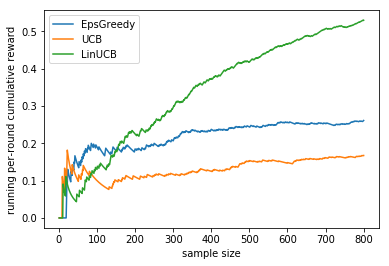

In [11]:
# Time plots for the running per-round cumulative reward for each algorithm ran earlier.

EpsGreedyPerRound = []
EpsGreedyRunningSum = 0
for i in range(len(results_EpsGreedy)):
    EpsGreedyRunningSum += results_EpsGreedy[i]
    EpsGreedyPerRound.append(EpsGreedyRunningSum/(i+1))
EpsGreedyPerRoundArray = np.array(EpsGreedyPerRound)

UCBPerRound = []
UCBRunningSum = 0
for i in range(len(results_UCB)):
    UCBRunningSum += results_UCB[i]
    UCBPerRound.append(UCBRunningSum/(i+1))
UCBPerRoundArray = np.array(UCBPerRound)

LinPerRound = []
LinRunningSum = 0
for i in range(len(results_LinUCB)):
    LinRunningSum += results_LinUCB[i]
    LinPerRound.append(LinRunningSum/(i+1))
LinPerRoundArray = np.array(LinPerRound)

sampleSize = np.arange(800)
sampleSize+=1

_, ax = plt.subplots()
ax.plot(sampleSize, EpsGreedyPerRoundArray, label = "EpsGreedy")
ax.plot(sampleSize, UCBPerRoundArray, label = "UCB")
ax.plot(sampleSize, LinPerRoundArray, label = "LinUCB")
plt.legend()
plt.xlabel('sample size')
plt.ylabel('running per-round cumulative reward')
plt.show()

### 4.B.

Text(0,0.5,'LinUCB result')

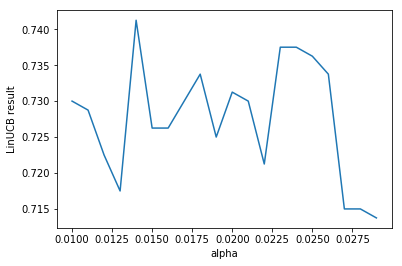

In [12]:
alphaList = []
resultList = []
# After plugging in various values of alpha, I chose this range to plot so I could illustrate a peak.
for bigAlpha in range(10,30):
    alpha = bigAlpha/1000
    alphaList.append(alpha)
    mab = LinUCB(10,10,alpha)
    results_LinUCB = offlineEvaluate(mab, arms,rewards,contexts, 800)
    resultList.append(np.mean(results_LinUCB))
_, ax = plt.subplots()
alphaArray = np.array(alphaList)
resultArray = np.array(resultList)
ax.plot(alphaArray, resultList)
plt.xlabel('alpha')
plt.ylabel('LinUCB result')

## 5. KernelUCB

In [13]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [14]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
# BONUS MARKS. YAY.
        
    